# Visualize text data

# 1)- Importing key modules

In [1]:
#support both Python 2 and Python 3 with minimal overhead.
from __future__ import absolute_import, division, print_function
import warnings
warnings.filterwarnings('ignore')

In [2]:
#https://textblob.readthedocs.io/en/dev/install.html
from textblob import TextBlob, Word, Blobber
from textblob.classifiers import NaiveBayesClassifier
from textblob.taggers import NLTKTagger

In [3]:
import re    # for regular expressions 
import nltk  # for text manipulation 
#For other text data
from collections import Counter
import scattertext as st
import spacy
from pprint import pprint
import en_core_web_sm
nlp = spacy.load('en_core_web_sm')

import string 
import numpy as np 
import pickle
import pandas as pd 
from sklearn.feature_extraction.text import CountVectorizer
#For Visuals
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from matplotlib import rcParams
rcParams['figure.figsize'] = 11, 8
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [4]:
# For dynamic visuals
import plotly.graph_objs as go
from plotly.offline import iplot
#import plotly.plotly as py
import cufflinks

In [5]:
%reload_ext version_information
%version_information pandas,numpy, nltk, seaborn, matplotlib

Software versions
Python 3.7.7 64bit [MSC v.1916 64 bit (AMD64)]
IPython 7.13.0
OS Windows 10 10.0.17763 SP0
pandas 1.0.3
numpy 1.18.1
nltk 3.5
seaborn 0.10.1
matplotlib 3.1.3
Wed Jun 17 17:03:30 2020 W. Europe Daylight Time

# 2)- Loading Dataset

In [6]:
data=pd.read_excel('data_10000_eng.xlsx')
data=data[['firstmessage','dep','firstusedtextblock']].astype(str)
data.shape

(9477, 3)

In [7]:
data.head()

firstmessage  \
0  Hello:<br><br>I tried to apply a voucher to th...   
1  <br>Hi,<br><br>Do you have a tracking number p...   
2  <p>Hi,<br /><br />I&rsquo;ve received my order...   
3  I was asked to test a saal photobook and I was...   
4  <p><br />Ainda n&atilde;o recebi a encomenda e...   

                                                 dep firstusedtextblock  
0                                    Shipping issues       nichtkombiwb  
1                                    Shipping issues            renscom  
2  product complaints - products (Reklamation Pro...           neupverp  
3                                      ShareWithSaal            teilen2  
4                                   Order management            renscom

In [8]:
data.dep.value_counts()

Order management                                        4766
product complaints - products (Reklamation Produkte)     816
Software/Webshop/App                                     776
Shipping issues                                          482
Customer feedback                                        461
ShareWithSaal                                            354
Payment (Bezahlung)                                      321
product complaints - colours (Reklamation Farben)        257
Product (Produkt)                                        252
Marketing                                                155
Bewerbungen SDF - MAL                                    126
Professional area (Profibereich)                         122
Special conditions                                       121
Production delays                                        115
Rücksendung                                              101
Bewerbungen SDF - RTB Office                              58
Reseller workflow       

### 2.1 Missing value

In [9]:
# Checking rows now
def summary_missing(dataset):
    n_miss = dataset.isnull().sum()
    n_obs = dataset.shape[0]
    n_miss_per = n_miss/n_obs*100
    n_miss_tbl = pd.concat([n_miss, n_miss_per], axis = 1).sort_values(1, ascending = False).round(1)
    n_miss_tbl = n_miss_tbl[n_miss_tbl[1] != 0]
    print('No. of fields: ', dataset.shape[0])
    print('No. of missing fields: ', n_miss_tbl.shape[0])
    n_miss_tbl = n_miss_tbl.rename(columns = {0:'No. of mising Value', 1:'%age of missing Value'})
    return n_miss_tbl

In [10]:
summary_missing(data)

No. of fields:  9477
No. of missing fields:  0


Empty DataFrame
Columns: [No. of mising Value, %age of missing Value]
Index: []

In [11]:
data=data.fillna('other')

In [12]:
summary_missing(data)

No. of fields:  9477
No. of missing fields:  0


Empty DataFrame
Columns: [No. of mising Value, %age of missing Value]
Index: []

### 2.2 Quick preprocessing aka cleaning

In [13]:
def preprocess(ReviewText):
    ReviewText = ReviewText.str.replace("(<br>)", "")
    ReviewText = ReviewText.str.replace("(<br />)", "")
    ReviewText = ReviewText.str.replace('(<p>)', '')
    ReviewText = ReviewText.str.replace('(;</p>)', '')
    ReviewText = ReviewText.str.replace('(&rsquo;)', '')
    ReviewText = ReviewText.str.replace('(&rdquo;)', '')
    ReviewText = ReviewText.str.replace('(&ldquo;)', '')
    ReviewText = ReviewText.str.replace('(&nbsp)', ' ')  
    ReviewText = ReviewText.str.replace('(www)', ' ') 
    ReviewText = ReviewText.str.replace('(https)', ' ') 
    ReviewText = ReviewText.str.replace('(http)', ' ') 
    return ReviewText
data['clean'] = preprocess(data['firstmessage'])

In [14]:
data.head()

firstmessage  \
0  Hello:<br><br>I tried to apply a voucher to th...   
1  <br>Hi,<br><br>Do you have a tracking number p...   
2  <p>Hi,<br /><br />I&rsquo;ve received my order...   
3  I was asked to test a saal photobook and I was...   
4  <p><br />Ainda n&atilde;o recebi a encomenda e...   

                                                 dep firstusedtextblock  \
0                                    Shipping issues       nichtkombiwb   
1                                    Shipping issues            renscom   
2  product complaints - products (Reklamation Pro...           neupverp   
3                                      ShareWithSaal            teilen2   
4                                   Order management            renscom   

                                               clean  
0  Hello:I tried to apply a voucher to this order...  
1  Hi,Do you have a tracking number please? Thank...  
2  Hi,Ive received my order but one of the poster...  
3  I was asked to test a saal photobook and I was...  
4  Ainda n&atilde;o recebi a encomenda e estive s...

In [15]:
data.firstmessage[2]

'<p>Hi,<br /><br />I&rsquo;ve received my order but one of the posters was in bad state.&nbsp;<br /><br />It was folded. &nbsp;La post sent me an email saying they had to &ldquo;reinforce&rdquo; the packaging.<br /><br />The order was 512005251803340<br /><br />Regards,<br /><br />Eugenia Sebastiani&nbsp;<br /><br /></p>'

In [16]:
data.clean[2]

'Hi,Ive received my order but one of the posters was in bad state. ;It was folded.  ;La post sent me an email saying they had to reinforce the packaging.The order was 512005251803340Regards,Eugenia Sebastiani '

### 2.3 Creating features : sentiments 

This is for checking sense of data i.e complaints might have negative sentiments while some feebacks could have positive sentiments.

In [17]:
data['polarity'] = data['clean'].map(lambda text: TextBlob(text).sentiment.polarity)
data['text_len'] = data['clean'].astype(str).apply(len)
data['word_count'] = data['clean'].apply(lambda x: len(str(x).split()))

In [18]:
print('5 random firstmessages with the highest positive sentiment polarity: \n')
data.loc[data.polarity == 1, ['clean']].sample(5)


5 random firstmessages with the highest positive sentiment polarity: 



clean
6580  hello, I ordered order no. 501910311807175, po...
7609  Dear Employee,  I've a question concerning the...
2049  Product review . Very happy with the quality, ...
2290  The best photobook out of 50 that our family h...
8259  Dear Sirs,  I’ve just proceed with payment by ...

In [19]:
print('5 random firstmessages with the highest neutral sentiment polarity: \n')
data.loc[data.polarity == 0, ['clean']].sample(5)

5 random firstmessages with the highest neutral sentiment polarity: 



clean
8796  I do have some questions as I downloaded the e...
9110  Dobry den, stav moje objednavky je ze nebola z...
7145  Dobrý den,  směřuji k Vám možná duplicitní dot...
1725  Hi, I am using OX 10.15.4I downloaded your sof...
5039  Dobr&yacute; den,už m&aacute;m objedn&aacute;n...

In [20]:
print('5 random firstmessages with the highest negative sentiment polarity: \n')
data.loc[data.polarity < 0, ['clean']].sample(5)

5 random firstmessages with the highest negative sentiment polarity: 



clean
7010  Hello  I ordered a photo album where the name ...
1022  I'm trying to ship a book to my mother in Virg...
8848  Hello, I would have such a plea. Wouldn't it b...
2872  Dzień dobryPoprawny adres do wysyłki toWaldema...
2055  Dear Ilse,I was unable to download the design ...

In [21]:
data.to_pickle('visual.pkl')

### characteristic terms and their associations

In [22]:
corpus = st.CorpusFromPandas(data, category_col='dep', text_col='clean', nlp=nlp).build()
print(list(corpus.get_scaled_f_scores_vs_background().index[:10]))

['saal', 'nan', 'jsem', 'photobook', 'bestelling', 'bych', 'jullie', 'ik', 'fotoboek', 'siegen']


Above are the terms that differentiate the text messages from a general English corpus

In [23]:
term_freq_df = corpus.get_term_freq_df()
term_freq_df['Order management Score'] = corpus.get_scaled_f_scores('Order management')
pprint(list(term_freq_df.sort_values(by='Order management Score', ascending=False).index[:10]))

['společnost saal',
 'společnost',
 'podle',
 'možné',
 'objednávce',
 'náklady',
 'potvrzení',
 'pagamento',
 'společnosti saal',
 'nebo']


Above are the terms in first message text that are most associated with the Order Management department

In [24]:
term_freq_df = corpus.get_term_freq_df()
term_freq_df['ShareWithSaal'] = corpus.get_scaled_f_scores('ShareWithSaal')
pprint(list(term_freq_df.sort_values(by='ShareWithSaal', ascending=False).index[:10]))

['to share',
 'share my',
 'share',
 'showcase',
 'absolutely love',
 'social media',
 'this photobook',
 'social',
 'to showcase',
 'absolutely']


This makes more sense as these words represent some meanings

In [25]:
term_freq_df['Customer feedback'] = corpus.get_scaled_f_scores('Customer feedback')
pprint(list(term_freq_df.sort_values(by='Customer feedback', ascending=False).index[:10]))

['intuitive',
 'was easy',
 'liked',
 'and easy',
 'easy to',
 'easy',
 'use and',
 'layouts',
 'comment',
 'software was']


# 3)-Visualize text data

### 3.1)-Understanding the common words
wordcloud

#### Before cleaning text

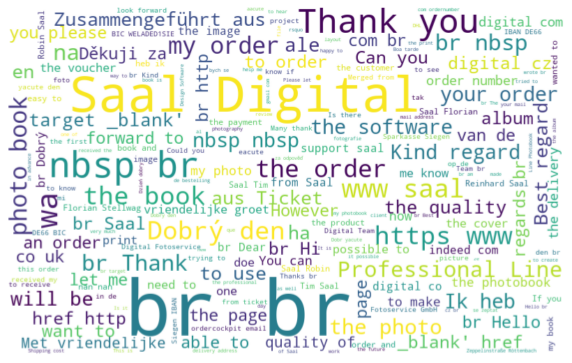

In [26]:
from wordcloud import WordCloud
all_words = ' '.join([text for text in data['firstmessage']])
wordcloud = WordCloud(width=800, height=500,background_color='white', random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### after Text cleaning

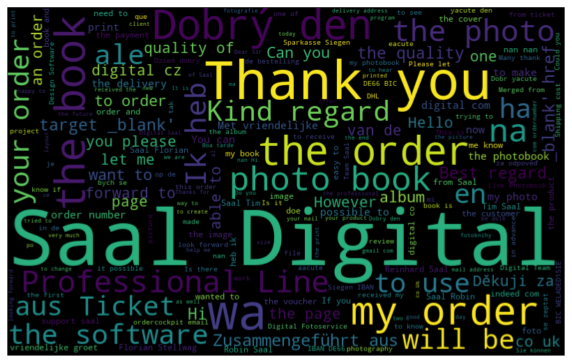

In [27]:
all_words = ' '.join([text for text in data['clean']])
wordcloud = WordCloud(width=800, height=500,background_color='black', random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### 3.2)- For 'Order management' class

#### Before cleaning

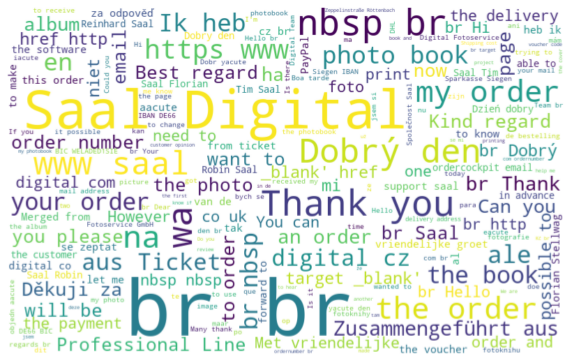

In [28]:
normal_words =' '.join([text for text in data['firstmessage'][data['dep'] == "Order management"]])

wordcloud = WordCloud(width=800, height=500,background_color='white', random_state=21, max_font_size=110).generate(normal_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### after cleaning

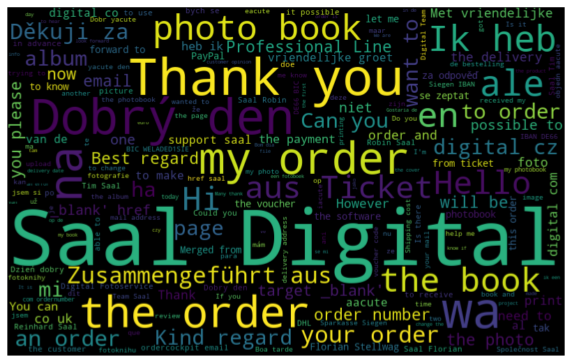

In [29]:
normal_words =' '.join([text for text in data['clean'][data['dep'] == "Order management"]])

wordcloud = WordCloud(width=800, height=500,background_color='black', random_state=21, max_font_size=110).generate(normal_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### 3.3)-For 'ShareWithSaal' class

#### Before cleaning 

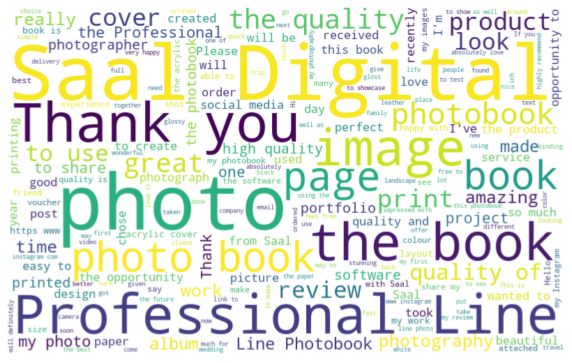

In [30]:
normal_words =' '.join([text for text in data['firstmessage'][data['dep'] == "ShareWithSaal"]])

wordcloud = WordCloud(width=800,background_color='white', height=500, random_state=21, max_font_size=110).generate(normal_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

#### after cleaning

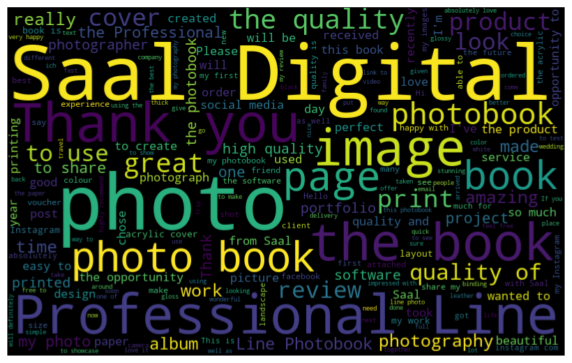

In [31]:
normal_words =' '.join([text for text in data['clean'][data['dep'] == "ShareWithSaal"]])

wordcloud = WordCloud(width=800,background_color='black', height=500, random_state=21, max_font_size=110).generate(normal_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

# 4)- Text before and after cleanup

### The distribution of top unigrams before cleaning data

In [32]:
from sklearn.feature_extraction.text import CountVectorizer

br 30338
the 17374
to 12036
and 7875
you 6129
is 5733
of 5514
in 5183
saal 4984
my 4897
it 4835
for 4304
de 4190
digital 3710
order 3612
have 3316
on 3145
nbsp 3095
your 3002
this 2878


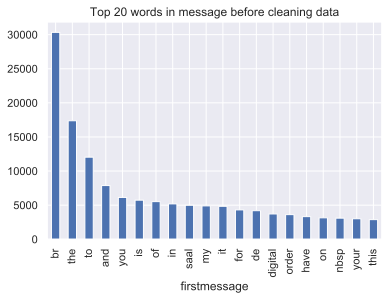

In [33]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(data['firstmessage'], 20)
for word, freq in common_words:
    print(word, freq)
df1 = pd.DataFrame(common_words, columns = ['firstmessage' , 'count'])
df1.groupby('firstmessage').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',title='Top 20 words in message before cleaning data')

### The distribution of top unigrams after cleaning data

saal 4924
digital 3701
order 3608
ik 2458
na 2380
book 2173
com 1795
se 1649
het 1492
photo 1482
aacute 1448
den 1403
thank 1381
van 1374
een 1357
software 1352
nan 1281
je 1272
en 1244
jsem 1232


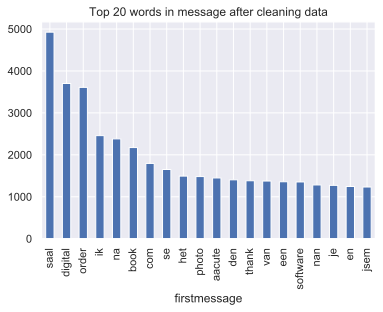

In [34]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = 'english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(data['clean'], 20)
for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['firstmessage' , 'count'])
df2.groupby('firstmessage').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 words in message after cleaning data')

Check the difference and see how many useful and relevant words we got in our vocabulary after data cleanup

### The distribution of top "bigrams" before cleanup

br br 12761
saal digital 3536
nbsp br 1524
of the 1397
thank you 1396
in the 1210
on the 907
for the 800
www saal 791
dobrý den 769
https www 747
to the 717
the book 717
the order 703
with the 688
my order 668
you can 665
and the 607
br nbsp 588
if you 575


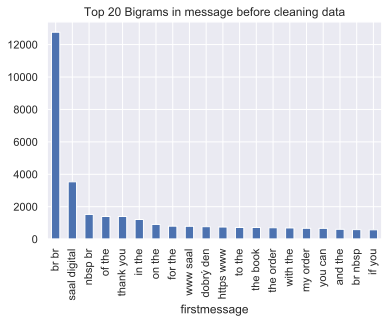

In [35]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(data['firstmessage'], 20)
for word, freq in common_words:
    print(word, freq)
df3 = pd.DataFrame(common_words, columns = ['firstmessage' , 'count'])
df3.groupby('firstmessage').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 Bigrams in message before cleaning data')

### The distribution of top "bigrams" after cleanup

saal digital 3472
dobrý den 768
photo book 570
professional line 548
ik heb 461
target _blank 459
kind regards 427
aus ticket 386
zusammengeführt aus 384
_blank href 362
best regards 359
digital cz 302
děkuji za 296
digital com 268
met vriendelijke 264
order number 259
let know 246
digital uk 235
vriendelijke groet 234
support saal 229


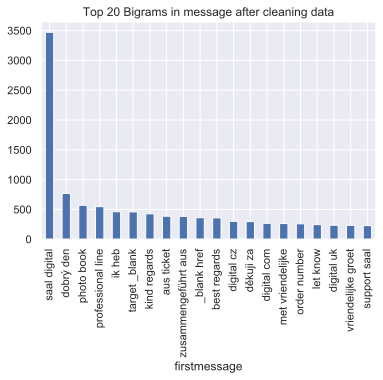

In [36]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_bigram(data['clean'], 20)
for word, freq in common_words:
    print(word, freq)
df3 = pd.DataFrame(common_words, columns = ['firstmessage' , 'count'])
df3.groupby('firstmessage').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 Bigrams in message after cleaning data')

Due to some other languages, I still got some unusual words like ik heb, dobrý den, met vriendelijke kč. This is where very hardcore cleaning techniques could be implemented. Also I am not sure if they mean anything. A better dataset with only english based dataset would be better to reflection any outcome from this visualization.

### The distribution of Top "Trigrams" before cleaning

br br br 4185
nbsp br br 829
www saal digital 791
br nbsp br 444
would like to 433
https www saal 391
thank you for 384
zusammengeführt aus ticket 384
target _blank href 362
br saal digital 357
saal digital cz 355
br thank you 338
nbsp nbsp nbsp 314
br br saal 293
saal digital com 265
http www saal 244
br br thank 235
let me know 226
support saal digital 224
saal digital co 224


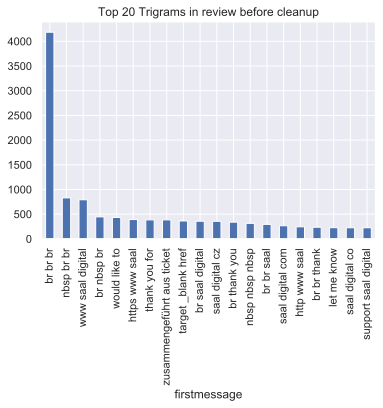

In [37]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(data['firstmessage'], 20)
for word, freq in common_words:
    print(word, freq)
df5 = pd.DataFrame(common_words, columns = ['firstmessage' , 'count'])
df5.groupby('firstmessage').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 Trigrams in review before cleanup')


### The distribution of Top "Trigrams" after cleaning

zusammengeführt aus ticket 384
target _blank href 362
saal digital com 262
saal digital cz 251
saal digital uk 234
support saal digital 226
reinhard saal robin 205
saal robin saal 205
robin saal tim 205
saal tim saal 205
tim saal florian 205
met vriendelijke groet 201
saal florian stellwag 199
de66 4605 0001 195
4605 0001 0000 195
0001 0000 0681 195
saal digital fotoservice 194
0000 0681 71 194
sparkasse siegen iban 193
siegen iban de66 193


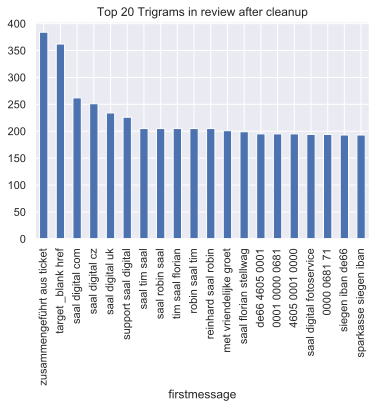

In [38]:
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_trigram(data['clean'], 20)
for word, freq in common_words:
    print(word, freq)
df5 = pd.DataFrame(common_words, columns = ['firstmessage' , 'count'])
df5.groupby('firstmessage').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 Trigrams in review after cleanup')

Highest 3 gram word is not English.

### The distribution of top part-of-speech tags 

It is important for next stages (perhaps) if we would go onto path of finding nouns and verbs aka Entity and Intents

In [39]:
import nltk
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hassan.sherwani\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

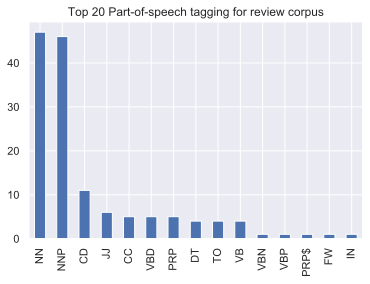

In [40]:
blob = TextBlob(str(data['firstmessage']))
pos_df = pd.DataFrame(blob.tags, columns = ['word' , 'pos'])
pos_df = pos_df.pos.value_counts()[:20]
pos_df.plot(
    kind='bar',
    x='POS',
    y='count', 
    title='Top 20 Part-of-speech tagging for review corpus')

What are these parts of speech abbreviations about

- https://pythonprogramming.net/part-of-speech-tagging-nltk-tutorial/

# 5)- Departments Role

- What do the departments tell about Sentiment polarity

In [41]:
data.dep.value_counts()

Order management                                        4766
product complaints - products (Reklamation Produkte)     816
Software/Webshop/App                                     776
Shipping issues                                          482
Customer feedback                                        461
ShareWithSaal                                            354
Payment (Bezahlung)                                      321
product complaints - colours (Reklamation Farben)        257
Product (Produkt)                                        252
Marketing                                                155
Bewerbungen SDF - MAL                                    126
Professional area (Profibereich)                         122
Special conditions                                       121
Production delays                                        115
Rücksendung                                              101
Bewerbungen SDF - RTB Office                              58
Reseller workflow       

In [42]:
y0 = data.loc[data['dep'] == 'Order management']['polarity']
y1 = data.loc[data['dep'] == 'ShareWithSaal']['polarity']
y2 = data.loc[data['dep'] == 'Customer feedback']['polarity']
y3 = data.loc[data['dep'] == 'product complaints - products (Reklamation Produkte)']['polarity']
y4 = data.loc[data['dep'] == 'Shipping issues']['polarity']
y5 = data.loc[data['dep'] == 'Software/Webshop/App']['polarity']

In [43]:
trace0 = go.Box(
    y=y0,
    name = 'Order management',
    marker = dict(
        color = 'rgb(214, 12, 140)',
    )
)
trace1 = go.Box(
    y=y1,
    name = 'ShareWithSaal',
    marker = dict(
        color = 'rgb(0, 128, 128)',
    )
)
trace2 = go.Box(
    y=y2,
    name = 'Customer feedback',
    marker = dict(
        color = 'rgb(10, 140, 208)',
    )
)
trace3 = go.Box(
    y=y3,
    name = 'product complaints-products',
    marker = dict(
        color = 'rgb(12, 102, 14)',
    )
)
trace4 = go.Box(
    y=y4,
    name = 'Shipping issues',
    marker = dict(
        color = 'rgb(10, 0, 100)',
    )
)
trace5 = go.Box(
    y=y5,
    name = 'product complaints-colours',
    marker = dict(
        color = 'rgb(100, 0, 10)',
    )
)
data = [trace0, trace1, trace2, trace3, trace4, trace5]
layout = go.Layout(
    title = "Sentiment Polarity Boxplot of Department Name"
)

fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "Sentiment Polarity Boxplot of Department Name")

- This data holds sanity for customer feedback being NOT too negative
- For product complaints, most text is actual of positive polarity. Either textblock has made mistake or our data is misleading. I think textblob is correct. Our data is composed of back and forth messages between customers and support centre. These sentences would have positive polarity in summation even though customer originally wrote a negative comment
- Order management has too many negative comment
- Shipping issues has mixture of both and is mostly seem like a neutral territoriy 

### 5.2)-first message length by department

In [44]:
import pickle
data=pd.read_pickle('visual.pkl')

In [45]:
data['dep'].value_counts()

Order management                                        4766
product complaints - products (Reklamation Produkte)     816
Software/Webshop/App                                     776
Shipping issues                                          482
Customer feedback                                        461
ShareWithSaal                                            354
Payment (Bezahlung)                                      321
product complaints - colours (Reklamation Farben)        257
Product (Produkt)                                        252
Marketing                                                155
Bewerbungen SDF - MAL                                    126
Professional area (Profibereich)                         122
Special conditions                                       121
Production delays                                        115
Rücksendung                                              101
Bewerbungen SDF - RTB Office                              58
Reseller workflow       

In [46]:
y0 = data.loc[data['dep'] == 'Order management']['text_len']
y1 = data.loc[data['dep'] == 'ShareWithSaal']['text_len']
y2 = data.loc[data['dep'] == 'Customer feedback']['text_len']
y3 = data.loc[data['dep'] == 'product complaints - products (Reklamation Produkte']['text_len']
y4 = data.loc[data['dep'] == 'Software/Webshop/App']['text_len']
y5 = data.loc[data['dep'] == 'Shipping issues']['text_len']

In [47]:
trace0 = go.Box(
    y=y0,
    name = 'Order management',
    marker = dict(
        color = 'rgb(214, 12, 140)',
    )
)
trace1 = go.Box(
    y=y1,
    name = 'ShareWithSaal',
    marker = dict(
        color = 'rgb(0, 128, 128)',
    )
)
trace2 = go.Box(
    y=y2,
    name = 'Customer feedback',
    marker = dict(
        color = 'rgb(10, 140, 208)',
    )
)
trace3 = go.Box(
    y=y3,
    name = 'product complaints',
    marker = dict(
        color = 'rgb(12, 102, 14)',
    )
)
trace4 = go.Box(
    y=y4,
    name = 'Software/Webshop/App',
    marker = dict(
        color = 'rgb(10, 0, 100)',
    )
)
trace5 = go.Box(
    y=y5,
    name = 'Shipping issues',
    marker = dict(
        color = 'rgb(100, 0, 10)',
    )
)
data = [trace0, trace1, trace2, trace3, trace4, trace5]
layout = go.Layout(
    title = "First message length Boxplot of Department Name"
)

fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "Message Length Boxplot of Department Name")

In [48]:
data=pd.read_pickle('visual.pkl')
y0 = data.loc[data['dep'] == 'Order management']['text_len']
y1 = data.loc[data['dep'] == 'ShareWithSaal']['text_len']
y2 = data.loc[data['dep'] == 'Customer feedback']['text_len']
y3 = data.loc[data['dep'] == 'product complaints - products (Reklamation Produkte']['text_len']
y4 = data.loc[data['dep'] == 'Software/Webshop/App']['text_len']
y5 = data.loc[data['dep'] == 'Shipping issues']['text_len']

In [49]:
trace0 = go.Histogram(
    y=y0,
    name = 'Order management',
    opacity=0.75
)
trace1 = go.Histogram(
    y=y1,
    name = 'ShareWithSaal',
    opacity=0.75  
)
trace2 = go.Histogram(
    y=y2,
    name = 'Customer feedback',
    opacity=0.75
)
trace3 = go.Histogram(
    y=y3,
    name = 'product complaints',
    opacity=0.75
)
trace4 = go.Histogram(
    y=y4,
    name = 'Software/Webshop/App',
    opacity=0.75
)
trace5 = go.Histogram(
    y=y5,
    name = 'Shipping issues',
    opacity=0.75
)
data = [trace0, trace1, trace2, trace3, trace4, trace5]
layout = go.Layout(barmode = 'group', title='Distribution of Message Lengths Based on Department')

fig = go.Figure(data=data,layout=layout)
iplot(fig, filename = "Stacked Histogram")

Compared to previous dataset, we have more data symetry. Almost all key classes have very narrow mean however; outliers in terms of sentence length are in abundance

I suspect reason is that we do not have strict data about 1st customer message rather a back and forth disucssion. And some texts may have longer msgz from customer support that makes these outliers. For a good analysis, outlier needs to be fixed and this data is no exception. We will have a better model if we have 1st customer message only.

# Reference

- https://towardsdatascience.com/a-complete-exploratory-data-analysis-and-visualization-for-text-data-29fb1b96fb6a